In [1]:
import sys
sys.path.insert(0, "../..")
import config as cfg
import gc
import os
from tqdm.notebook import tqdm
from helper import check_path, seed_everything
from collections import defaultdict

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [4]:
EXPERIMENT_FAMILY_NAME = 'keras'
EXPERIMENT_NAME = 'labse_big'
N_RANDOM_SEEDS = 1
N_EPOCHS = 100
BATCH_SIZE = 8
N_SPLITS = 5

In [5]:
RANDOM_STATE = 77
seed_everything(RANDOM_STATE)

In [6]:
def filter_rare_categories(df: pd.DataFrame) -> pd.DataFrame:
    rare_categories = [12]
    return df.loc[~df[cfg.TARGET].isin(rare_categories)]

In [7]:

train = pd.read_pickle(os.path.join(cfg.PREPROCESSED_DATA_PATH, 'train.pkl'))
test = pd.read_pickle(os.path.join(cfg.PREPROCESSED_DATA_PATH, 'test.pkl'))

train = train.rename(columns={cfg.TEXT_COL: 'text'})
test = test.rename(columns={cfg.TEXT_COL: 'text'})

CLASSES = np.sort(train[cfg.TARGET].unique()).tolist()

# train = filter_rare_categories(train)

In [8]:
# EMB_NAME = 'smaller_LaBSE_15lang'
# train_emb = pd.read_pickle(os.path.join(cfg.DATA_PATH, EMB_NAME, 'train.pkl'))
# test_emb = pd.read_pickle(os.path.join(cfg.DATA_PATH, EMB_NAME, 'test.pkl'))

# train = train.join(train_emb)
# test = test.join(test_emb)

# del train_emb, test_emb; gc.collect()

In [9]:
X_train, y_train = train.drop(cfg.TARGET, axis=1), train[cfg.TARGET]
y_train_onecol = y_train.copy()

# y_train = pd.get_dummies(y_train)

N_OUT_CLASSES = len(CLASSES)
# assert y_train.shape[1] == N_OUT_CLASSES

In [10]:
theme_train = pd.read_csv(cfg.ORIG_TRAIN_PATH, index_col=cfg.ID_COL, usecols=[cfg.ID_COL, cfg.THEME_COL])
theme_train = theme_train[cfg.THEME_COL].astype('category').cat.codes
N_THEMES = theme_train.nunique()
# theme_train = pd.get_dummies(theme_train)
# theme_train.columns = [f'theme_{i}' for i in range(theme_train.shape[1])]


In [11]:
pred_proba_oof = pd.DataFrame(data=np.zeros(shape=(len(train), len(CLASSES))), index=train.index, columns=CLASSES)
pred_proba_test = pd.DataFrame(data=np.zeros(shape=(len(test), len(CLASSES))), index=test.index, columns=CLASSES)

In [12]:
from typing import Optional


def df_to_dataset(data: pd.DataFrame, labels: Optional[pd.DataFrame]=None, shuffle: bool=True, batch_size: int=32, labels2: Optional[pd.DataFrame]=None):
  df = data.copy()
  df = {key: value.values[:, tf.newaxis] for key, value in data.items()}
  
  if labels is None:
    ds = tf.data.Dataset.from_tensor_slices((dict(df),))
  else:
    ds = tf.data.Dataset.from_tensor_slices((
      dict(df), 
      {
        'category_out': labels, 
        'theme_out': labels2
        }
        ))
        
  if shuffle:
    ds = ds.shuffle(buffer_size=len(data))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds


def get_keras_input(
    data: pd.DataFrame,
    labels: Optional[pd.DataFrame] = None,
    labels2: Optional[pd.DataFrame] = None,
    shuffle=False
    ) -> tf.data.Dataset:
    return df_to_dataset(
        data=data,
        labels=labels,
        labels2=labels2,
        shuffle=shuffle, 
        batch_size=BATCH_SIZE)
        


In [13]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2", name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/google/LaBSE/2", trainable=False, name='encoder')
    outputs = encoder(encoder_inputs)
    def_pool_out = outputs['pooled_output']
    max_pool_out = tf.keras.layers.GlobalMaxPooling1D()(outputs['sequence_output'])
    net = tf.keras.layers.Concatenate()([def_pool_out, max_pool_out])
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(300, activation=None)(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    category_out = tf.keras.layers.Dense(N_OUT_CLASSES, activation=None, name='category_out')(net)
    theme_out = tf.keras.layers.Dense(N_THEMES, activation=None, name='theme_out')(net)
    model = tf.keras.Model(
        text_input, 
        outputs={
            'category_out': category_out, 
            'theme_out': theme_out
            })

    loss = {
        'category_out': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='category_out'),
        'theme_out': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='theme_out')
        }
    # metrics = tf.keras.metrics.AUC(from_logits=True, name='auc')

    epochs = N_EPOCHS
    n = (len(train) // cfg.N_SPLITS) * (cfg.N_SPLITS-1)
    steps_per_epoch = n // BATCH_SIZE
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-4
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

    model.compile(optimizer=optimizer,
                         loss=loss,
                         loss_weights={"category_out": 2.0, "theme_out": 0.2}
                        #  metrics=metrics
                         )
    return model

In [14]:
leak_test = pd.read_pickle(os.path.join(cfg.DATA_PATH, 'test_leak.pkl'))
leak_mask = leak_test.notnull()

In [15]:
cv = StratifiedKFold(n_splits=N_SPLITS, random_state=cfg.RANDOM_STATE, shuffle=True)

test_pool = get_keras_input(
        data=test,
        shuffle=False
        )


metrics = defaultdict(list)
fold = 0
for train_idx, val_idx in tqdm(cv.split(X_train, y_train_onecol), total=N_SPLITS):

    train_pool = get_keras_input(
        data=X_train.iloc[train_idx], 
        labels=y_train.iloc[train_idx],
        labels2=theme_train.iloc[train_idx],
        shuffle=True
        )

    val_pool = get_keras_input(
        data=X_train.iloc[val_idx], 
        labels=y_train.iloc[val_idx],
        labels2=theme_train.iloc[val_idx],
        shuffle=False
        )
    
        
    for random_seed in tqdm(range(N_RANDOM_SEEDS), total=N_RANDOM_SEEDS):

        clf = build_classifier_model()
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_category_out_loss', patience=3, min_delta=1e-5, mode='auto', restore_best_weights=True)
        clf.fit(x=train_pool, validation_data=val_pool, epochs=N_EPOCHS, callbacks=[early_stopping])
        
        model_name = f'{EXPERIMENT_NAME}_fold_{fold}_rs_{random_seed}'
        model_path = os.path.join(cfg.MODELS_PATH, EXPERIMENT_FAMILY_NAME, EXPERIMENT_NAME)
        check_path(model_path)
        clf.save(os.path.join(model_path, model_name), include_optimizer=False)
        
        pred_proba_oof_val = tf.nn.softmax(clf.predict(val_pool)['category_out']).numpy()
        pred_proba_oof_train = tf.nn.softmax(clf.predict(train_pool)['category_out']).numpy()
        pred_proba_oof.iloc[val_idx, :] += pred_proba_oof_val
        pred_proba_test.iloc[:, :] += tf.nn.softmax(clf.predict(test_pool)['category_out']).numpy()

        y_val_oof = y_train_onecol.iloc[val_idx]

        val_auc = roc_auc_score(y_val_oof, pred_proba_oof_val , multi_class='ovo', labels=CLASSES)
        metrics['val_auc'].append(val_auc)
        print('val auc', val_auc)

        leak_test_auc_score = roc_auc_score(leak_test.loc[leak_mask], pred_proba_test.loc[leak_mask] / (fold + 1), multi_class='ovo', labels=CLASSES)
        metrics['leak_test_auc_score'].append(leak_test_auc_score)
        print('leak_test_auc_score', leak_test_auc_score)
        
        del clf; gc.collect()
    del train_pool,val_pool; gc.collect() 
        
    fold += 1
pred_proba_oof /= N_RANDOM_SEEDS
pred_proba_test /= (N_SPLITS * N_RANDOM_SEEDS)

2022-07-24 15:04:58.624147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 15:04:58.656724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 15:04:58.656908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 15:04:58.657519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

  0%|          | 0/5 [00:00<?, ?it/s]

/home/as/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

2022-07-24 15:05:06.625837: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1539542016 exceeds 10% of free system memory.


Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 8.7988 - category_out_loss: 3.7118 - theme_out_loss: 6.8760

2022-07-24 15:05:51.130687: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1539542016 exceeds 10% of free system memory.
2022-07-24 15:05:52.274379: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1539542016 exceeds 10% of free system memory.


200/200 [==============================] - 45s 192ms/step - loss: 8.7988 - category_out_loss: 3.7118 - theme_out_loss: 6.8760 - val_loss: 4.2422 - val_category_out_loss: 1.5722 - val_theme_out_loss: 5.4885
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 4.9406 - category_out_loss: 1.8908 - theme_out_loss: 5.7950

2022-07-24 15:06:28.653831: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1539542016 exceeds 10% of free system memory.


200/200 [==============================] - 36s 182ms/step - loss: 4.9406 - category_out_loss: 1.8908 - theme_out_loss: 5.7950 - val_loss: 3.1156 - val_category_out_loss: 1.0867 - val_theme_out_loss: 4.7107
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 3.7074 - category_out_loss: 1.3356 - theme_out_loss: 5.1813

2022-07-24 15:07:05.054836: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1539542016 exceeds 10% of free system memory.


200/200 [==============================] - 36s 182ms/step - loss: 3.7074 - category_out_loss: 1.3356 - theme_out_loss: 5.1813 - val_loss: 2.6850 - val_category_out_loss: 0.9018 - val_theme_out_loss: 4.4070
Epoch 4/100
200/200 [==============================] - 36s 182ms/step - loss: 3.0353 - category_out_loss: 1.0441 - theme_out_loss: 4.7355 - val_loss: 2.5610 - val_category_out_loss: 0.8752 - val_theme_out_loss: 4.0531
Epoch 5/100
200/200 [==============================] - 35s 177ms/step - loss: 2.7372 - category_out_loss: 0.9381 - theme_out_loss: 4.3052 - val_loss: 2.5621 - val_category_out_loss: 0.9029 - val_theme_out_loss: 3.7814
Epoch 6/100
200/200 [==============================] - 35s 177ms/step - loss: 2.5405 - category_out_loss: 0.8867 - theme_out_loss: 3.8349 - val_loss: 2.6343 - val_category_out_loss: 0.9757 - val_theme_out_loss: 3.4139
Epoch 7/100
200/200 [==============================] - 36s 182ms/step - loss: 2.3732 - category_out_loss: 0.8423 - theme_out_loss: 3.4426 - 

125/125 [==============================] - 16s 126ms/step
val auc 0.8276735993568999
leak_test_auc_score 0.8182043484081367


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/100
200/200 [==============================] - 44s 193ms/step - loss: 7.0671 - category_out_loss: 2.8435 - theme_out_loss: 6.9003 - val_loss: 4.1373 - val_category_out_loss: 1.5129 - val_theme_out_loss: 5.5574
Epoch 2/100
200/200 [==============================] - 36s 181ms/step - loss: 4.5020 - category_out_loss: 1.6582 - theme_out_loss: 5.9276 - val_loss: 3.2124 - val_category_out_loss: 1.1400 - val_theme_out_loss: 4.6623
Epoch 3/100
200/200 [==============================] - 36s 182ms/step - loss: 3.6513 - category_out_loss: 1.3036 - theme_out_loss: 5.2208 - val_loss: 2.6623 - val_category_out_loss: 0.9087 - val_theme_out_loss: 4.2247
Epoch 4/100
200/200 [==============================] - 35s 176ms/step - loss: 3.0448 - category_out_loss: 1.0509 - theme_out_loss: 4.7156 - val_loss: 2.6638 - val_category_out_loss: 0.9507 - val_theme_out_loss: 3.8126
Epoch 5/100
200/200 [==============================] - 36s 182ms/step - loss: 2.6881 - category_out_loss: 0.9146 - theme_out_los

KeyboardInterrupt: 

In [ ]:
oof_auc_score = roc_auc_score(y_train, pred_proba_oof , multi_class='ovo', labels=CLASSES)
print('oof_auc_score', oof_auc_score)
print('scores', metrics['val_auc'])
print('mean', np.mean(metrics['val_auc']), 'std', np.std(metrics['val_auc']))

oof_auc_score 0.8263713180555257
scores [0.8583115811191869, 0.8639834201802155, 0.8250048449331142]
mean 0.8490999487441723 std 0.01719443631590944


In [ ]:
# 0.8263713180555257

In [ ]:
leak_test = pd.read_pickle(os.path.join(cfg.DATA_PATH, 'test_leak.pkl'))
notnull = leak_test.notnull()
leak_test_auc_score = roc_auc_score(leak_test.loc[notnull], pred_proba_test.loc[notnull], multi_class='ovo', labels=CLASSES)
print('leak_test_auc_score', leak_test_auc_score)


leak_test_auc_score 0.8659094099087034


In [ ]:
# 0.8659094099087034

In [ ]:
submission = pd.read_csv(cfg.SAMPLE_SUBMIT_PATH).set_index('id')
assert submission.index.equals(pred_proba_test.index)
submission[cfg.TARGET] = pred_proba_test.idxmax(1)

submission_path = os.path.join(cfg.SUBMISSION_PATH, EXPERIMENT_FAMILY_NAME)
check_path(submission_path)
submission.to_csv(os.path.join(submission_path, f'{EXPERIMENT_NAME}.csv'))

pred_proba_oof_path = os.path.join(cfg.OOF_PRED_PATH, EXPERIMENT_FAMILY_NAME)
check_path(pred_proba_oof_path)
pred_proba_oof.to_pickle(os.path.join(pred_proba_oof_path, f'{EXPERIMENT_NAME}.pkl'))

pred_proba_test_path = os.path.join(cfg.TEST_PRED_PATH, EXPERIMENT_FAMILY_NAME)
check_path(pred_proba_test_path)
pred_proba_test.to_pickle(os.path.join(pred_proba_test_path, f'{EXPERIMENT_NAME}.pkl'))

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
trn_target_count = y_train.value_counts().rename('train_true')
trn_pred_count = pred_proba_oof.idxmax(1).value_counts().rename('train_pred')

In [ ]:
tst_target_count = leak_test.loc[leak_mask].astype('int').value_counts().rename('test_true')
tst_pred_count = submission.loc[leak_mask, cfg.TARGET].value_counts().rename('test_pred')

<AxesSubplot:>

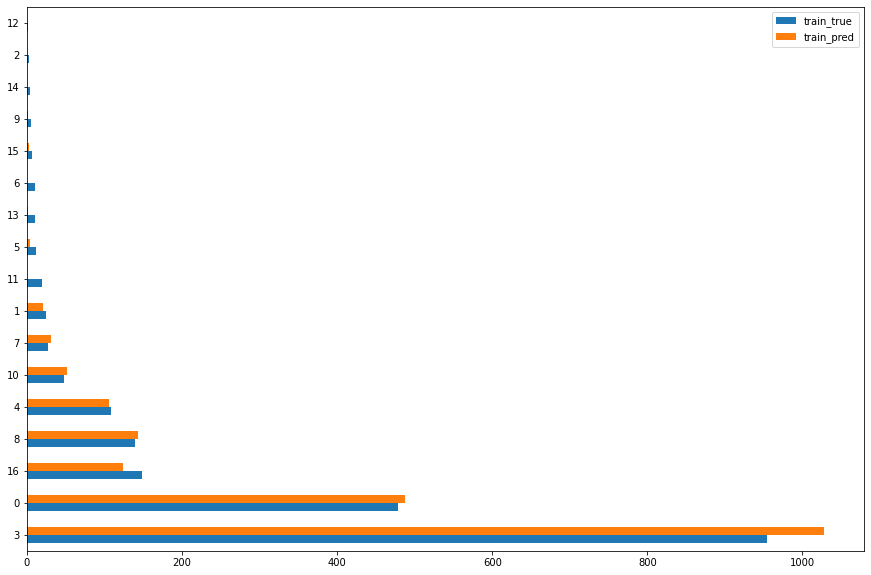

In [ ]:
pd.concat([trn_target_count, trn_pred_count], axis=1).plot(kind='barh', figsize=(15,10))

<AxesSubplot:>

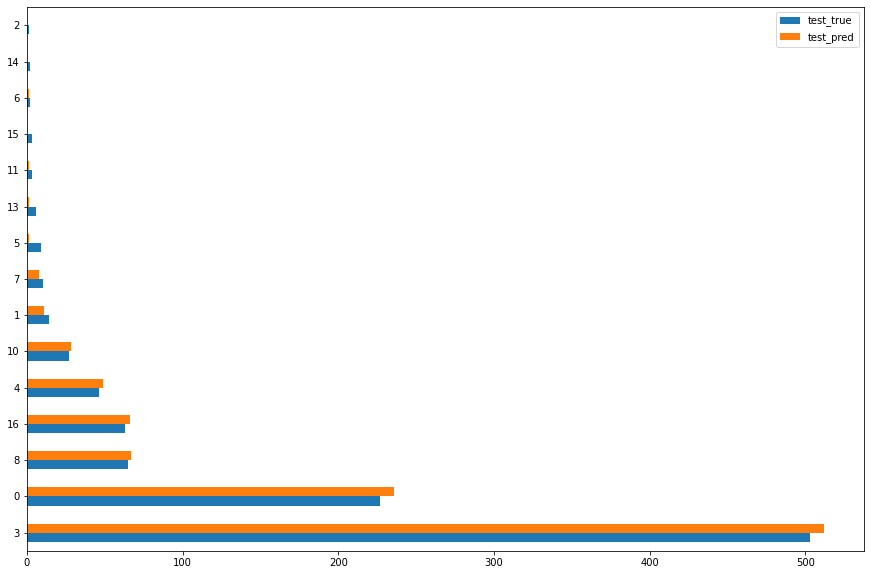

In [ ]:
pd.concat([tst_target_count, tst_pred_count], axis=1).plot(kind='barh', figsize=(15,10))